# Unsupervised learning: CNN-based autoencoder for image reconstruction and denoising

In this notebook, you will:

- Implement an autoencoder based on convolutional neural networks using TensorFlow
- Use the code to find similar images in the dataset
- Use the autoencoder to denoise noisy images


**NOTE for the solution: Try to increase the code size for the autoencoders to obtain better reconstructions.** It would be useful also to increase the number of samples used during training through the `tot_images` variable and to increase the number of training epochs.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from sklearn.model_selection import train_test_split
from dataset_utils import load_malaria_filenames, load_malaria_image, normalize_img
import matplotlib.pyplot as plt
import keras_utils
import numpy as np
import random
import os

%matplotlib inline
np.random.seed(1)

2022-11-27 11:31:32.171622: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Part I

## 1 - Malaria dataset

The Malaria dataset is a database of segmented cells from the thin blood smear slide images from the Malaria Screener research activity. The dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells.

You can find information about the dataset [here](https://lhncbc.nlm.nih.gov/LHC-research/LHC-projects/image-processing/malaria-screener.html).

The dataset is uploaded to the Google Drive folder of the laboratory. Please, unzip the file before continuing.

Let's start by loading the names of the image files using the `load_malaria_filenames` function in `dataset_utils.py`. Next, we will load the images through the methods in the TensorFlow Dataset class that we started using in Lab 2. This is more efficient with respect to loading the entire dataset immediately (remember the figure from Lab 2).

In [2]:
load_data_dir = './cell_images'
labels = ['Parasitized', 'Uninfected']
tot_images = 5000 # number of images to consider for each diagnosis, at maximum 13780

X, Y = load_malaria_filenames(load_data_dir, labels, tot_images)

Loading filenames completed.


In this laboratory, we are mostly concerned about the images (X) without much caring about the actual labels. The autoencoder is an unsupervised learning approach that can be used for dimensionality reduction or denoising purposes. The extracted features (the hidden layer) can then be used as input for a classifier trained to associate each image with the correct label (supervised learning) - we will see it in detail below. 

In the next cell of code, use the `train_test_split` from `sklearn.model_selection` to split the dataset into train and test sets (documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)).

In [3]:
# split the dataset into train and test groups using the package sklearn
### START CODE HERE ### 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
### END CODE HERE ###

In [4]:
print("X shape:", len(X))
print("X train shape:", len(X_train))
print("X test shape:", len(X_test))
IMG_SHAPE = (100, 100, 3)

X shape: 9998
X train shape: 7998
X test shape: 2000


Visualize some images from the dataset.

In [5]:
def show_image(x):
    plt.imshow(x)

2022-11-27 11:31:34.354356: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-27 11:31:34.356064: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


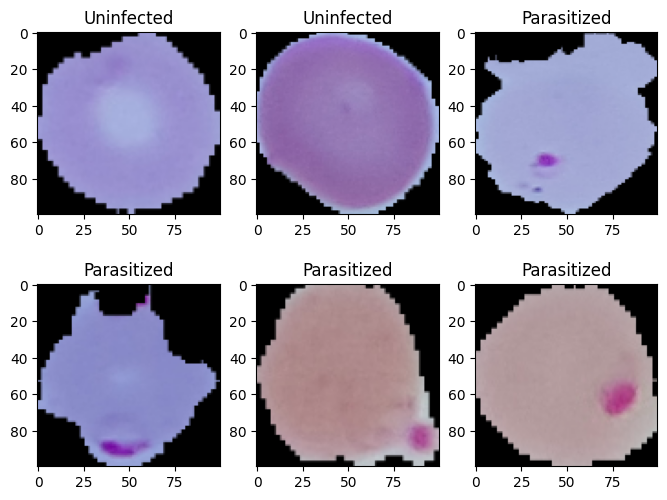

In [6]:
plt.figure(figsize=(8, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    idx = random.randint(0, len(Y_train))
    show_image(normalize_img(load_malaria_image(X_train[idx])))
    plt.title(labels[Y_train[idx]])

## 2 - Autoencoder architecture and dataset definition

We will now design the autoencoder as two sequential TF-Keras models: the encoder and decoder.

We will then use the TF-Keras built-in methods to compile and train these models.

<center><img src="images/autoencoder.png" style="width:40%"></center>
<center><img src="images/autoencoder_images.png" style="width:60%"></center>
<caption><center> Autoencoder structure</center></caption><br>

### 2.1 - Create the train and test datasets
Let's define the `create_dataset` function, which initializes a `tf.data.Dataset` object and properly maps all the required processing. 

In Lab 2 you saw a simple pipeline using `tf.data.Dataset`. The pipeline implemented here below is more advanced: let's analyze the code step by step.

#### - **Create a Dataset object**
We use the method `from_tensor_slices` to instantiate a `tf.data.Dataset` object, which iteratively gets data from given tensors (documentation [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices)). Specifically, we use as an argument a tuple composed of all the information we want to include in the Dataset. In our case, we only need the `file_names` list (\['image1.png', 'image2.png', ...\]) that corresponds to the `X` (`X_train` and `X_test` respectively) defined above. We will see in Lab 5 how to include also the labels for a supervised task.
Hint: use 
```
tf.data.Dataset.from_tensor_slices((file_names))
```

#### - **Map the load_and_preprocess_data function**
Remember that the `map()` method (documentation [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map)) of the dataset allows the transformation of the elements of the dataset. In this case, we want to transform the filename string to a 32-bit tensor containing the actual images using the `load_malaria_image` function. Next, we want to apply another `map()` to normalize the image through the `normalize_img` function.

If the mapped function only uses built-in TensorFlow methods (which support tf tensors, e.g., *tf.cast()*, *tf.add()*, *tf.div()*, ...), you can directly pass it to the `.map(function)` method, as you did in Lab 2, section 3.2. This is the case for the second mapping operation, i.e., the one that applies the `normalize_image` function.

Instead, the `load_malaria_image` function uses external functions (e.g., the `imread` from opencv). In order to include arbitrary python functions inside the TensorFlow graph, we need to use `tf.numpy_function` (you can find more information [here](https://www.tensorflow.org/api_docs/python/tf/numpy_function)).
The downside of using custom python functions is that they cannot leverage the TensorFlow optimized logic (e.g., fast matrix multiplication on GPUs). Nevertheless, sometimes, especially when analyzing signals, we need (or want) this flexibility, accepting and considering the cost.

**NOTE**: By setting the *num_parallel_calls* parameter of the `.map()` function, you can easily parallelize your computation by spawning different processes. In this case, data are concurrently loaded and processed from files using all your available CPU cores!

The `map()` function converts your dataset entries from (filename) to (image).

#### - **Cache the dataset**
This is one of the most interesting features of the TensorFlow Dataset API. With a single line of code, you can implement an advanced caching system.

Let's consider a practical use case. In this example, the normalization step can be performed a single time on the entire dataset, since the result is always the same (*deterministic preprocessing*). Repeating these steps every time you load data is a waste of computational time and is highly inefficient. To avoid multiple executions of the same function we can leverage the *cache* method. In this way, the output of the dataset is only evaluated the first time, and all the subsequent calls will load data from the stored cache. The cache can store partial results both in a file or in memory (RAM), see the [documentation](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) for more details.

**IMPORTANT NOTE**: The order of the dataset transformations is very important, especially when using a caching system. We will see below a practical example.

#### - **Shuffle**
This allows the data to be sampled in a different order on every epoch. Documentation [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle).

**NOTE**: The `shuffle()` method requires a buffer to be filled **before** it can start to sample data (the buffer size is set by the *buffer_size* parameter). In this case, we are setting the shuffle buffer size equal to the dataset size. So, before starting to sample, the dataset must load all the data, and it can require some time in the beginning, especially if you are still creating the cache.

#### - **Repeat the dataset indefinitely**
The `repeat()` method simply tells the dataset to start again when it runs out of samples. Documentation [here](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#repeat). Without this step, each file would be loaded only one time during training, resulting in an error in the `fit()` method (as the last batch will be smaller than the others).

#### - **Batch**
Put together *batch_size* samples into a single batch of data, which will be the input of the network. The shape of the data changes from (100, 100, 3) to (batch_size, 100, 100, 3).

#### - **Prefetch**
While a process is training your network, this operation allows loading and processing the subsequent chunk of data at the same time, greatly improving the idle time.

In [7]:
def create_dataset(file_names, batch_size, shuffle, cache_file=None):
    
    # Create a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices((file_names))

    # Map the load_malaria_image function
    py_func = lambda file_name: (tf.numpy_function(load_malaria_image, [file_name], tf.float32))
    dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

    # Map the normalize_img function
    dataset = dataset.map(normalize_img, num_parallel_calls=os.cpu_count())

    # Duplicate data for the autoencoder (input = output)
    py_funct = lambda img: (img, img)
    dataset = dataset.map(py_funct)

    # Cache dataset
    if cache_file:
        dataset = dataset.cache(cache_file)

    # Shuffle
    if shuffle:
        dataset = dataset.shuffle(len(file_names))

    # Repeat the dataset indefinitely
    dataset = dataset.repeat()

    # Batch
    dataset = dataset.batch(batch_size=batch_size)

    # Prefetch
    dataset = dataset.prefetch(buffer_size=1)

    return dataset

### 2.2 - Dataset initialization
Now we can finally define our train and test datasets.

We also evaluate the number of steps (*train_steps* and *test_steps*) required to load and process the entire dataset (num. of samples / batch_size).

In [8]:
batch_size = 32
train_dataset = create_dataset(X_train,
                               batch_size=batch_size,
                               shuffle=True,
                               cache_file='train_cache')

test_dataset = create_dataset(X_test,
                              batch_size=batch_size,
                              shuffle=False,
                              cache_file='val_cache')

train_steps = int(np.ceil(len(X_train) / batch_size))
test_steps = int(np.ceil(len(X_test) / batch_size))

## 3 - First step: PCA as a simple autoencoder

Looking back to the first topic from the theory: the principal component analysis dimensionality reduction technique. 
We saw the PCA in Lab 2 but... let's revise it and try to implement this technique through a neural network!

The goal of PCA is to find a new basis to re-express the dataset $X \in \mathbb{R}^{n \times m}$. The new basis is obtained as a linear combination of the original basis and the dataset after applying PCA is obtained as $Y=XP$ with $P \in \mathbb{R}^{m \times m}$ and $Y \in \mathbb{R}^{n \times m}$.

After PCA we can decide to retain a lower number of dimensions $d < m$ to reduce the dimensionality of the input space and hence we obtain $\hat{Y}=XW$ with $W \in \mathbb{R}^{m \times d}$.

The objective is to minimize the mean square error between $\hat{Y}$ and $X$:

$$\|(X W) \hat{W} - X\|^2_2$$
where $\hat{W} \in \mathbb{R}^{d \times m}$ is the matrix of reverse transformation.

In geometric terms, we want to find d axes along which most of the variance occurs. 

PCA can be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense (d neurons) -> code
* __Decoder__: code -> Dense (m neurons) -> X

Where Dense is a fully-connected layer with linear activation: $f(X) = W \cdot X + b $. The bias term is responsible for subtracting the mean value.


### 3.1 - Build a simple linear autoencoder

Create below the Keras models for the encoder and the decoder. Use the approach you prefer for the definition of the model (class `keras.Model` or `keras.Sequential`). If you want, experiment with `keras.Sequential` adding the layers through the `add()` method (documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#add)):

```python
encoder = tf.keras.Sequential()
encoder.add(layers.Flatten())
....
```

Note: when you define a model, you can also start by passing a `tf.keras.Input` object to the model, so that it knows its input shape from the start. This option is useful if you want to visualize your model (`mode.summary()`) before passing the input data.
If you don't add it at the beginning (like here above), the model will be instantiated the first time it will receive an input tensor (documentation [here](https://www.tensorflow.org/guide/keras/sequential_model#specifying_the_input_shape_in_advance)). 

```python
encoder = tf.keras.Sequential()
encoder.add(tf.keras.Input(IMG_SHAPE))
encoder.add(layers.Flatten())
....
```

In [9]:
# FUNCTION: define a simple linear autoencoder as described above

def build_pca_autoencoder(img_shape, code_size):
    """
    Arguments:
    img_shape_x -- size of the input layer
    code_size -- the size of the hidden representation of the input (code)
    
    Returns:
    encoder -- keras model for the encoder network
    decoder -- keras model for the decoder network
    """

    # encoder, use the following layers: tf.keras.Input(...), layers.Flatten(), layers.Dense(...)
    ### START CODE HERE ### 
    encoder = tf.keras.Sequential()
    encoder.add(tf.keras.Input(img_shape))
    encoder.add(layers.Flatten())          # flatten image to vector
    encoder.add(layers.Dense(code_size))   # actual encoder
    ### END CODE HERE ### 

    # decoder, use the following layers: tf.keras.Input(...), layers.Dense(...), layers.Reshape(...)
    ### START CODE HERE ### 
    decoder = tf.keras.Sequential()
    decoder.add(tf.keras.Input((code_size,)))
    decoder.add(layers.Dense(np.prod(img_shape))) # actual decoder, height*width*3 neurons
    decoder.add(layers.Reshape(img_shape))        # un-flatten
    ### END CODE HERE ###
    
    return encoder, decoder

Try to run the cell below with and without the following instructions in the encoder and in the decoder models (in the second case you will have an error message, see the explanation above and in the documentation).
```python
encoder.add(tf.keras.Input(IMG_SHAPE))
decoder.add(tf.keras.Input((code_size,)))
```

In [10]:
# call the above function to create the encoder and decoder models, use code_size=32
### START CODE HERE ### 
encoder, decoder = build_pca_autoencoder(IMG_SHAPE, code_size=32)
### END CODE HERE ### 

encoder.summary()
decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 30000)             0         
                                                                 
 dense (Dense)               (None, 32)                960032    
                                                                 
Total params: 960,032
Trainable params: 960,032
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 30000)             990000    
                                                                 
 reshape (Reshape)           (None, 100, 100, 3)       0         
                                                                 
Total params: 990,000
Traina

Now, use the encoder and the decoder models in sequence to build the autoencoder model.

In [11]:
# 1- instantiate the input tensor (hint: use tf.keras.Input(IMG_SHAPE))
# 2- get the code (output of the encoder)
# 3- pass the code to the decoder and get the reconstruction
### START CODE HERE ### 
inp = tf.keras.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)
### END CODE HERE ### 

# create the autoencoder model: use tf.keras.Model() with the correct input and output tensors from the line above
### START CODE HERE ### 
autoencoder = tf.keras.Model(inputs=inp, outputs=reconstruction)
### END CODE HERE ### 

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 32)                960032    
                                                                 
 sequential_1 (Sequential)   (None, 100, 100, 3)       990000    
                                                                 
Total params: 1,950,032
Trainable params: 1,950,032
Non-trainable params: 0
_________________________________________________________________


### 3.2 - Fit the autoencoder network on the training data and evaluate its performance

In [12]:
# compile and fit the model

autoencoder.compile(optimizer='adamax', loss='mse') 
autoencoder.fit(train_dataset, 
                epochs=10,
                steps_per_epoch=train_steps,
                validation_data=test_dataset,
                validation_steps=test_steps)

Epoch 1/10
  3/250 [..............................] - ETA: 17s - loss: 0.6114

2022-11-27 11:31:40.699742: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


250/250 [==============================] - 31s 103ms/step - loss: 0.0508 - val_loss: 0.0345
Epoch 2/10
  1/250 [..............................] - ETA: 20s - loss: 0.0379

2022-11-27 11:32:06.342765: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


250/250 [==============================] - 20s 80ms/step - loss: 0.0330 - val_loss: 0.0313
Epoch 3/10
250/250 [==============================] - 17s 67ms/step - loss: 0.0297 - val_loss: 0.0283
Epoch 4/10
250/250 [==============================] - 19s 78ms/step - loss: 0.0263 - val_loss: 0.0248
Epoch 5/10
250/250 [==============================] - 21s 82ms/step - loss: 0.0233 - val_loss: 0.0223
Epoch 6/10
250/250 [==============================] - 18s 71ms/step - loss: 0.0212 - val_loss: 0.0206
Epoch 7/10
250/250 [==============================] - 19s 78ms/step - loss: 0.0197 - val_loss: 0.0193
Epoch 8/10
250/250 [==============================] - 19s 78ms/step - loss: 0.0184 - val_loss: 0.0179
Epoch 9/10
250/250 [==============================] - 17s 70ms/step - loss: 0.0171 - val_loss: 0.0166
Epoch 10/10
250/250 [==============================] - 19s 78ms/step - loss: 0.0158 - val_loss: 0.0154


In [13]:
# FUNCTION: draws original, encoded and decoded images

def visualize(img, encoder, decoder):
    """
    Arguments:
    img -- original image
    encoder -- trained encoder network
    decoder -- trained decoder network
    """
    
    code = encoder.predict(img[np.newaxis, :])[0] # img[np.newaxis, :] is used to add an additional axis 
                                                  # Remember that the model takes as input a 4-dimensional array (?, height, width, channels) where the first dimension 
                                                  # is the one related to the mini-batch size. Here our "mini-batch" is composed of a single image
    reco = decoder.predict(code[None])[0] # img[None] is the same as img[np.newaxis, :]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

PCA MSE: 0.015413652174174786
1/1 [==============================] - 0s 69ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


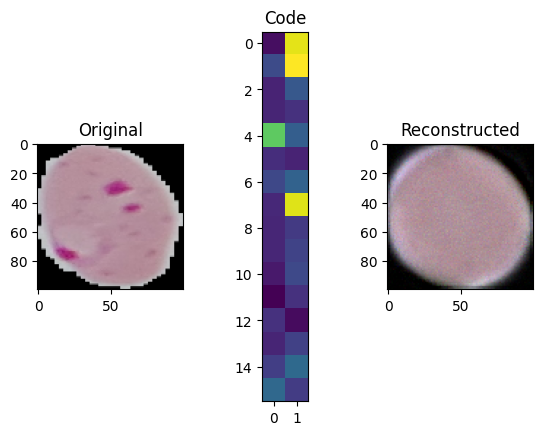

1/1 [==============================] - 0s 70ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


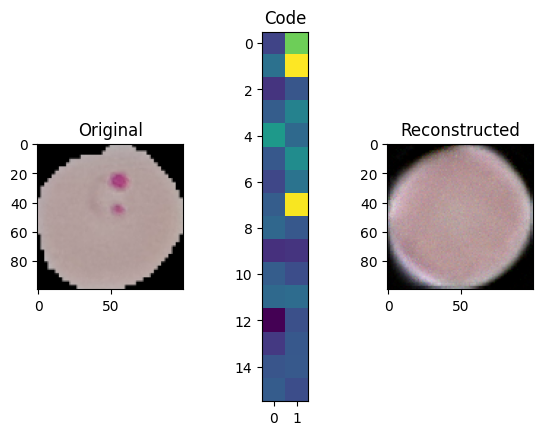

1/1 [==============================] - 0s 40ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


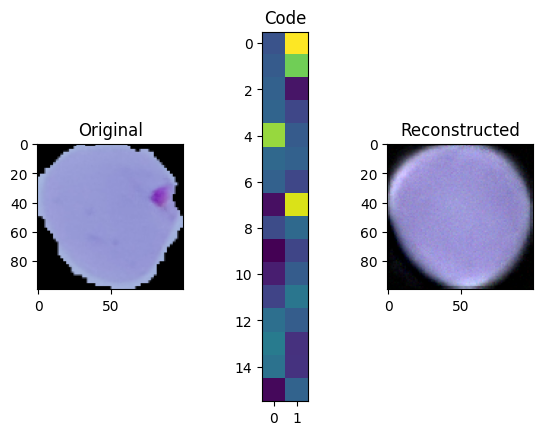

1/1 [==============================] - 0s 48ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


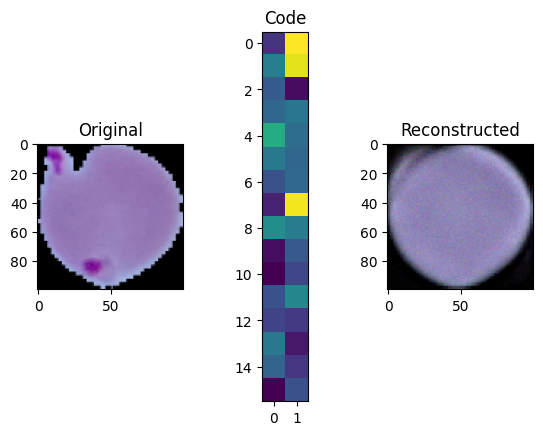

1/1 [==============================] - 0s 36ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


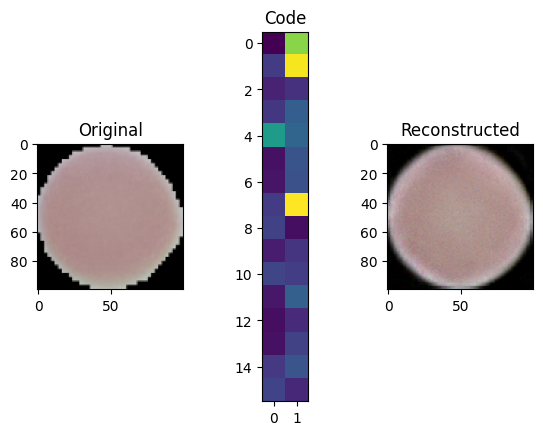

In [14]:
loss = autoencoder.evaluate(test_dataset, steps=test_steps, verbose=0)
print("PCA MSE:", loss)

for i in range(5):
    idx = random.randint(0, len(X_test))
    img = normalize_img(load_malaria_image(X_test[idx]))
    visualize(img, encoder, decoder)

## 4 - Going deeper: convolutional autoencoder

Now, try to implement a deep convolutional autoencoder by stacking more layers.

### 4.1 - Encoder

The **encoder** part is pretty standard and it is obtained by stacking convolutional and pooling layers and finishing with a dense layer to get the representation of the desirable size (`code_size`).


Suggested architecture:

- use `activation='elu'` for all convolutional and dense layers

- repeat (conv, pool) 4 times with kernel size (3, 3), `padding='same'` and the following numbers of output channels: `32, 64, 128, 256`

Remember to flatten (`layers.Flatten()`) output before adding the last dense layer to get your code.


### 4.2 - Decoder

For **decoder** we will use the so-called "transposed convolution". 

The traditional convolutional layer takes a patch of an image and produces a number (patch -> number). In "transposed convolution" we want to take a number and produce a patch of an image (number -> patch). We need this layer to "undo" convolutions in the encoder.

<center><img src="images/transpose_conv.jpg" style="width:55%"></center>
<caption><center> Transposed convolution </center></caption><br>

Suggested architecture:

- start with a dense layer to "undo" the last layer of the encoder ` layers.Dense(6*6*256)`

- reshape the output of the dense layer to "undo" `layers.Flatten()` in the encoder (hint: use `layers.Reshape((6, 6, 256))`)

- undo the (conv, pool) pairs in the encoder by stacking 4 `layers.Conv2DTranspose` layers with the following numbers of output channels: `128, 64, 32, 3`. Use a stride of 2 to produce 4x4 output: in this way, you "undo" pooling as well. Documentation [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose). Use `padding='same'` for all the layers except the second one (with 64 feature maps) where you need to use `padding='valid'` otherwise you will have dimensionality issues.

- for the last `layers.Conv2DTranspose` layer use `activation=None` because that is our final image

In [15]:
# FUNCTION: define a convolutional autoencoder as described above

def build_deep_autoencoder(img_shape, code_size):
    """
    Arguments:
    img_shape_x -- size of the input layer
    code_size -- the size of the hidden representation of the input (code)

    Returns:
    encoder -- keras model for the encoder network
    decoder -- keras model for the decoder network
    """

    # encoder
    ### START CODE HERE ###
    encoder = tf.keras.Sequential()
    encoder.add(tf.keras.Input(img_shape))

    encoder.add(layers.Conv2D(32, (3, 3), activation='elu', padding='same'))
    encoder.add(layers.MaxPool2D((2, 2), padding='same'))

    encoder.add(layers.Conv2D(64, (3, 3), activation='elu', padding='same'))
    encoder.add(layers.MaxPool2D((2, 2), padding='same'))

    encoder.add(layers.Conv2D(128, (3, 3), activation='elu', padding='same'))
    encoder.add(layers.MaxPool2D((2, 2), padding='same'))

    encoder.add(layers.Conv2D(256, (3, 3), activation='elu', padding='same'))
    encoder.add(layers.MaxPool2D((2, 2), padding='same'))

    encoder.add(layers.Flatten())
    encoder.add(layers.Dense(code_size))
    ### END CODE HERE ###

    # decoder
    ### START CODE HERE ###
    decoder = tf.keras.Sequential()
    decoder.add(tf.keras.Input((code_size,)))

    decoder.add(layers.Dense(6 * 6 * 256, activation='elu'))
    decoder.add(layers.Reshape((6, 6, 256)))

    decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, activation='elu', padding='same'))

    decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, activation='elu', padding='valid'))

    decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, activation='elu', padding='same'))
    
    decoder.add(layers.Conv2DTranspose(3, (3, 3), strides=2, activation=None, padding='same'))
    ### END CODE HERE ###

    return encoder, decoder

In [16]:
# check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1, 8, 32, 128, 512]:
    
    encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=code_size)
    print("Testing code size %i" % code_size)
    assert encoder.output_shape[1:] == (code_size,), "encoder must output a code of required size"
    assert decoder.output_shape[1:] == IMG_SHAPE, "decoder must output an image of valid shape"
    assert len(encoder.trainable_weights) >= 6, "encoder must contain at least 3 layers"
    assert len(decoder.trainable_weights) >= 6, "decoder must contain at least 3 layers"

    for layer in encoder.layers + decoder.layers:
        assert get_dim(layer) >= code_size, "Encoder layer %s is smaller than bottleneck (%i units)" % (layer.name, get_dim(layer))

print("All tests passed!")

Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
All tests passed!


In [17]:
# Look at encoder and decoder shapes. The total number of trainable parameters of encoder and decoder should be close
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.summary()
decoder.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 25, 25, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 25, 25, 128)       73856     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 13, 13, 128)    

### 4.3 - Build the autoencoder and train it on the Malaria dataset

Convolutional autoencoder training.

In [18]:
# call the above function to create the encoder and decoder models, use code_size=32
### START CODE HERE ### 
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
### END CODE HERE ###

In [19]:
# build the deep autoencoder network

# 1- instantiate the input tensor (hint: use tf.keras.Input(IMG_SHAPE))
# 2- get the code (output of the encoder)
# 3- pass the code to the decoder and get the recunstruction
### START CODE HERE ### 
inp = tf.keras.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)
### END CODE HERE ### 

# create the autoencoder model: use tf.keras.Model() with the correct input and output tensors from the line above
### START CODE HERE ###
autoencoder = tf.keras.Model(inputs=inp, outputs=reconstruction)
### END CODE HERE ### 

autoencoder.compile(optimizer="adamax", loss='mse')

In [20]:
# with the next lines, you save model's checkpoints to continue training in case of kernel death
model_filename = 'autoencoder_network.hdf5'
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
# last_finished_epoch = 4 # replace with your latest finished epoch
# autoencoder = load_model(model_filename)
# encoder = autoencoder.layers[1]
# decoder = autoencoder.layers[2]

In [21]:
history = autoencoder.fit(train_dataset,
                          epochs=50,
                          steps_per_epoch=train_steps,
                          validation_data=test_dataset,
                          validation_steps=test_steps,
                          callbacks=[keras_utils.ModelSaveCallback(model_filename)],
                          verbose=0,
                          initial_epoch=last_finished_epoch or 0)

Epoch 0 - Model saved in autoencoder_network.hdf5
Epoch 1 - Model saved in autoencoder_network.hdf5
Epoch 2 - Model saved in autoencoder_network.hdf5
Epoch 3 - Model saved in autoencoder_network.hdf5
Epoch 4 - Model saved in autoencoder_network.hdf5
Epoch 5 - Model saved in autoencoder_network.hdf5
Epoch 6 - Model saved in autoencoder_network.hdf5
Epoch 7 - Model saved in autoencoder_network.hdf5
Epoch 8 - Model saved in autoencoder_network.hdf5
Epoch 9 - Model saved in autoencoder_network.hdf5
Epoch 10 - Model saved in autoencoder_network.hdf5
Epoch 11 - Model saved in autoencoder_network.hdf5
Epoch 12 - Model saved in autoencoder_network.hdf5
Epoch 13 - Model saved in autoencoder_network.hdf5
Epoch 14 - Model saved in autoencoder_network.hdf5
Epoch 15 - Model saved in autoencoder_network.hdf5
Epoch 16 - Model saved in autoencoder_network.hdf5
Epoch 17 - Model saved in autoencoder_network.hdf5
Epoch 18 - Model saved in autoencoder_network.hdf5
Epoch 19 - Model saved in autoencoder_net

If you want, take a look at the `ModelSaveCallback` class in the `keras_utils.py` file. This class extends the `tf.keras.callbacks.Callback` one. Callbacks are utilities called at certain points during the training process. Documentation can be found [here](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks) and [here](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback). One interesting callback is the one to apply [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping).
Here above we used a callback to save the model at the end of each epoch.

Convolutional autoencoder MSE: 0.006953753065317869
1/1 [==============================] - 0s 144ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


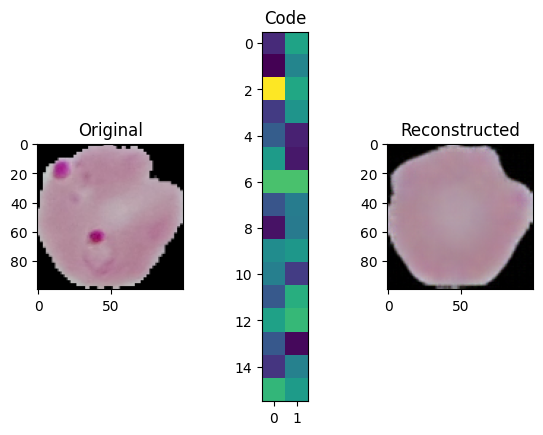

1/1 [==============================] - 0s 40ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


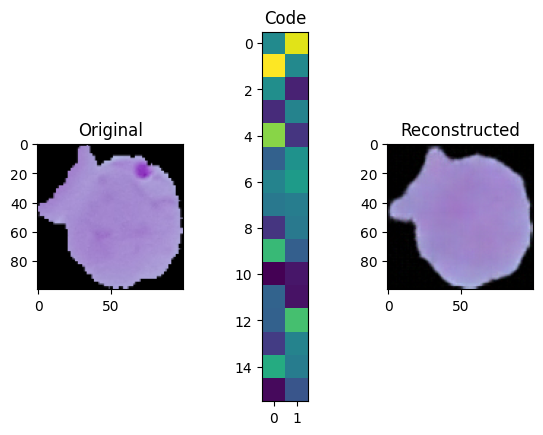

1/1 [==============================] - 0s 33ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


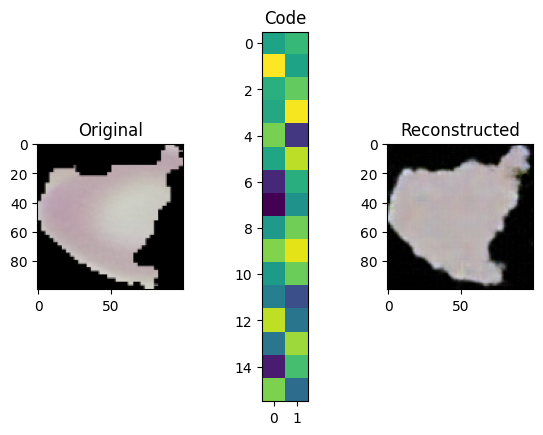

1/1 [==============================] - 0s 38ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


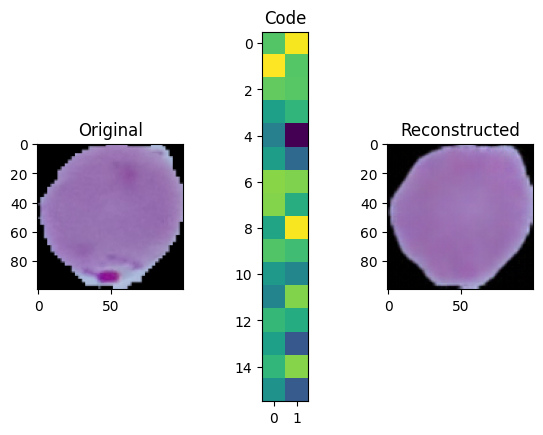

1/1 [==============================] - 0s 51ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


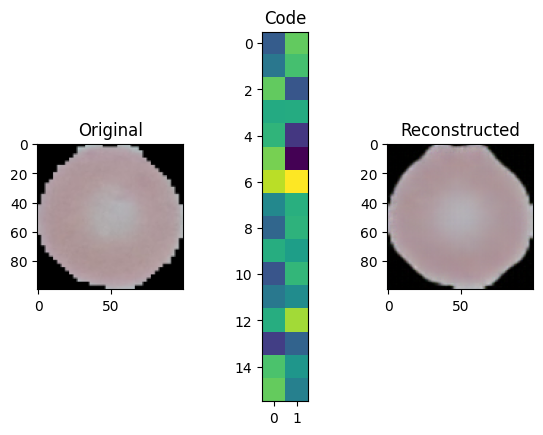

In [22]:
reconstruction_mse = autoencoder.evaluate(test_dataset, steps=test_steps, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)

for i in range(5):
    idx = random.randint(0, len(X_test))
    img = normalize_img(load_malaria_image(X_test[idx]))
    plt.figure()
    visualize(img, encoder, decoder)
    plt.show()

### 4.4 - Save the model parameters

Here below you can find two useful methods: `save_weights` ([documentation](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#save_weights)) and `load_weights` ([documentation](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#load_weights)). They allow you to store the parameters of your model and then re-use them without the need to re-training the network.

In [23]:
# save trained weights
encoder.save_weights("encoder.h5")
decoder.save_weights("decoder.h5")

In [24]:
# restore trained weights
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")
decoder.load_weights("decoder.h5")

inp = tf.keras.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = tf.keras.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

reconstruction_mse = autoencoder.evaluate(test_dataset, steps=test_steps, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)

Convolutional autoencoder MSE: 0.006953753065317869


# Part II 

## 5 - Image retrieval with autoencoders

So you have just trained a network that converts an image into itself imperfectly. This task is not that useful by itself, but it has awesome side effects. 

The first thing we can do is image retrieval or image search. For this purpose, the autoencoder receives as input an image and finds similar images using the codes (latent space).

<center><img src="images/similar_images.png" style="width:60%"><center>
<caption><center> Image search </center></caption><br>

Here below you will try to use the nearest neighbors algorithm to find similar images in the dataset. First of all, let's compute the code for all the images in the dataset.

In [25]:
# restore trained encoder weights
encoder, _ = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")

In [26]:
# encode the images in the training set (hint: use the method predict() applied to the encoder network and specify `steps=train_steps`)
### START CODE HERE ### 
codes = encoder.predict(train_dataset, steps=train_steps)
### END CODE HERE ### 

codes = codes[:len(X_train)] # to remove final duplicates used to complete the last batch
assert len(codes) == len(X_train)

250/250 [==============================] - 31s 122ms/step


Now, we use the unsupervised learner `sklearn.neighbors.NearestNeighbors` (documentation [here](https://scikit-learn.org/stable/modules/neighbors.html#unsupervised-neighbors) and [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) to group images in the dataset based on their similarities, in this case euclidean distance.

After the creation of the learner, call the `fit()` method to fit the model using the codes generated above (documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors.fit)).

In [27]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(metric="euclidean")

# fit the model using the codes
### START CODE HERE ###
nbrs.fit(codes)
### END CODE HERE ### 

NearestNeighbors(metric='euclidean')

In the next function the n_neighbors neighbors of the image passed as argument are returned. To do that:

- first, the code of the received image is computed

- then, the method `kneighbors` is called on the `nbrs` learner created above. This method returns the indices of the neighbors of the image in the dataset and distances to them (documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors.kneighbors)).

In [28]:
# FUNCTION: return the `n_neighbors` neighbors of `image` in the dataset

def get_similar(image, n_neighbors=5):

    code = encoder.predict(image[None])
    (distances,),(idx,) = nbrs.kneighbors(code, n_neighbors=n_neighbors)

    return distances, idx

In [29]:
# FUNCTION: visualize the `n_neighbors` neighbors of `image` in the dataset

def show_similar(image, X_train):
    
    distances, neighbors_idxs = get_similar(image, n_neighbors=3)
    
    plt.figure(figsize=[8,7])
    plt.subplot(1, 4, 1)
    show_image(image)
    plt.title("Original image")
    
    for i in range(3):
        plt.subplot(1, 4, i+2)
        show_image(normalize_img(load_malaria_image(X_train[neighbors_idxs[i]])))
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

Apply the functions to visualize some examples.

1/1 [==============================] - 0s 64ms/step


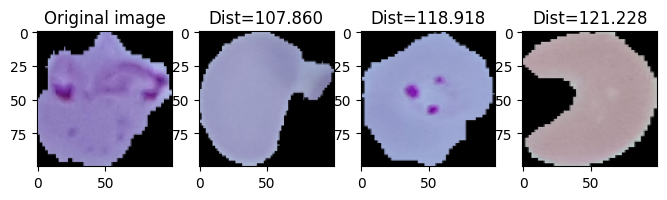

In [30]:
# smiles
show_similar(normalize_img(load_malaria_image(X_test[247])), X_train)

1/1 [==============================] - 0s 20ms/step


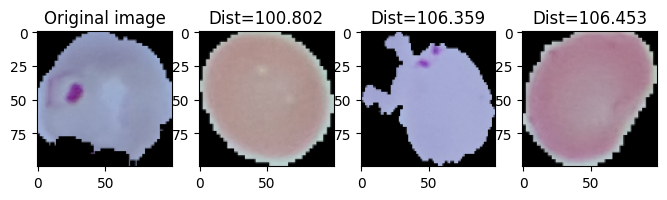

In [31]:
# ethnicity
show_similar(normalize_img(load_malaria_image(X_test[56])), X_train)

1/1 [==============================] - 0s 76ms/step


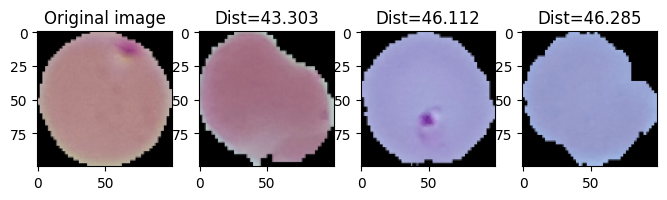

In [32]:
# glasses
show_similar(normalize_img(load_malaria_image(X_test[63])), X_train)

## 6 - Denoising autoencoder

One useful application of autoencoders is image denoising.

<center><img src="images/denoising.png" style="width:60%"></center>
<caption><center> Denoising autoencoder </center></caption><br>

Below, you will implement a denoising autoencoder by keeping the model architecture at point 4, but changing the way it is trained. Specifically, you will corrupt the input data randomly with noise before each epoch.

There are different strategies to introduce noise: adding white Gaussian noise, occluding with random black rectangles, etc.
Here, we use the first approach. Use `np.random.normal` (documentation [here](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html)).

In [33]:
# FUNCTION: add white Gaussian noise to the image

def apply_gaussian_noise(X, sigma=0.1):
    """
    Arguments:
    X -- image tensor of shape [batch, height, width, 3]
    sigma -- standard deviation for the gaussian noise

    Returns:
    X + noise --
    """
    ### START CODE HERE ###
    noise = np.random.normal(loc=0., scale=sigma, size=X.shape)
    ### END CODE HERE ###
    noise = noise.astype('float32')

    return X + noise

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


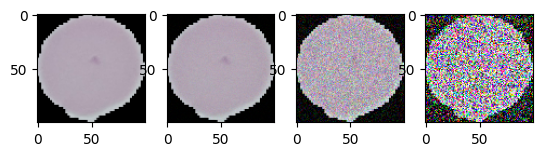

In [34]:
# test different noise scales
plt.subplot(1,4,1)
show_image(normalize_img(load_malaria_image(X_train[0])))
plt.subplot(1,4,2)
show_image(apply_gaussian_noise(load_malaria_image(X_train[0])/255., sigma=0.01)) 
plt.subplot(1,4,3)
show_image(apply_gaussian_noise(load_malaria_image(X_train[0])/255., sigma=0.1))
plt.subplot(1,4,4)
show_image(apply_gaussian_noise(load_malaria_image(X_train[0])/255., sigma=0.5))

### 6.1 - Create train and test datasets with noise

The process here is almost the same as the `create_dataset` function above but we need to change the input image in the dataset by adding Gaussian noise. 
**IMPORTANT NOTE**: The order of the dataset transformations is very important, especially when using a caching system. For example, if you apply the cache **after** the `apply_gaussian_noise` operation, your samples would be added with noise only the first time, and stored in the cache. All the subsequent calls would always return the same exact noise, resulting in both a waste of data and more overfitting issues.

In [35]:
def create_noisy_dataset(file_names, batch_size, shuffle, cache_file=None):
    # Create a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices((file_names))

    # Map the load_malaria_image function
    py_func = lambda file_name: (tf.numpy_function(load_malaria_image, [file_name], tf.float32))
    dataset = dataset.map(py_func, num_parallel_calls=os.cpu_count())

    # Map the normalize_img function
    dataset = dataset.map(normalize_img, num_parallel_calls=os.cpu_count())

    # Duplicate data for the autoencoder (input = output)
    py_funct = lambda img: (img, img)
    dataset = dataset.map(py_funct)

    # Cache dataset
    if cache_file:
        dataset = dataset.cache(cache_file)

    # Shuffle
    if shuffle:
        dataset = dataset.shuffle(len(file_names))

    # Repeat the dataset indefinitely
    dataset = dataset.repeat()

    # Map the apply_gaussian_noise function to add Gaussian noise to the input image
    py_funct = lambda img_in, img_out: (tf.numpy_function(apply_gaussian_noise, [img_in], tf.float32), img_out)
    dataset = dataset.map(py_funct)

    # Batch
    dataset = dataset.batch(batch_size=batch_size)

    # Prefetch
    dataset = dataset.prefetch(buffer_size=1)

    return dataset

In [36]:
batch_size = 32
train_dataset = create_noisy_dataset(
                                X_train,
                                batch_size=batch_size,
                                shuffle=True,
                                cache_file='train_cache')

test_dataset = create_noisy_dataset(
                                X_test,
                                batch_size=batch_size,
                                shuffle=False,
                                cache_file='val_cache')

train_steps = int(np.ceil(len(X_train) / batch_size))
test_steps = int(np.ceil(len(X_test) / batch_size))

### 6.2 - Train the denoising autoencoder

In [37]:
# we use bigger code size here for better quality
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)

inp = layers.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

denoising_autoencoder = tf.keras.Model(inp, reconstruction)
denoising_autoencoder.compile('adamax', 'mse')

model_filename = 'denoising_autoencoder_network.hdf5'
last_finished_epoch = None

# NOTE: with the create_noisy_dataset function, the noise is added independently at each epoch so at each epoch the images are corrupted differently --> good to learn better
history = denoising_autoencoder.fit(
                                train_dataset,
                                epochs=50,
                                steps_per_epoch=train_steps,
                                validation_data=test_dataset,
                                validation_steps=test_steps,
                                callbacks=[keras_utils.ModelSaveCallback(model_filename)],
                                verbose=0,
                                initial_epoch=last_finished_epoch or 0)

Epoch 0 - Model saved in denoising_autoencoder_network.hdf5
Epoch 1 - Model saved in denoising_autoencoder_network.hdf5
Epoch 2 - Model saved in denoising_autoencoder_network.hdf5
Epoch 3 - Model saved in denoising_autoencoder_network.hdf5
Epoch 4 - Model saved in denoising_autoencoder_network.hdf5
Epoch 5 - Model saved in denoising_autoencoder_network.hdf5
Epoch 6 - Model saved in denoising_autoencoder_network.hdf5
Epoch 7 - Model saved in denoising_autoencoder_network.hdf5
Epoch 8 - Model saved in denoising_autoencoder_network.hdf5
Epoch 9 - Model saved in denoising_autoencoder_network.hdf5
Epoch 10 - Model saved in denoising_autoencoder_network.hdf5
Epoch 11 - Model saved in denoising_autoencoder_network.hdf5
Epoch 12 - Model saved in denoising_autoencoder_network.hdf5
Epoch 13 - Model saved in denoising_autoencoder_network.hdf5
Epoch 14 - Model saved in denoising_autoencoder_network.hdf5
Epoch 15 - Model saved in denoising_autoencoder_network.hdf5
Epoch 16 - Model saved in denoisin

63/63 [==============================] - 13s 202ms/step - loss: 0.0069
Denoising MSE: 0.006944074761122465
1/1 [==============================] - 0s 145ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


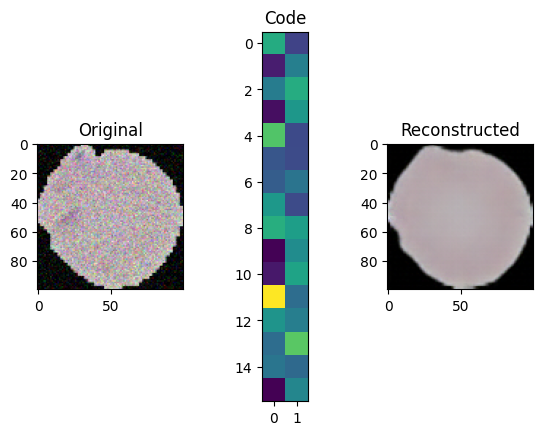

1/1 [==============================] - 0s 37ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


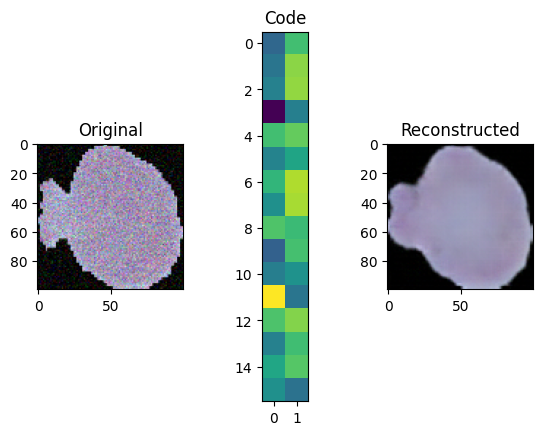

1/1 [==============================] - 0s 57ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


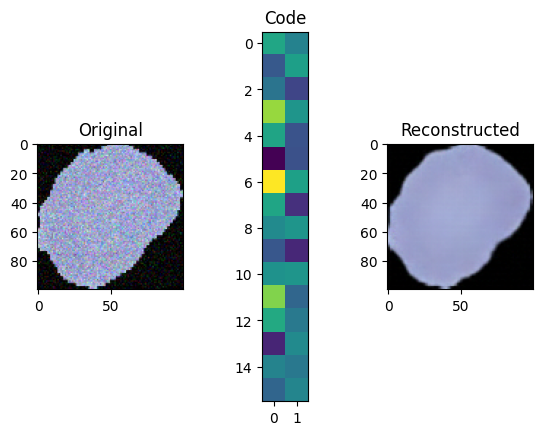

1/1 [==============================] - 0s 83ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


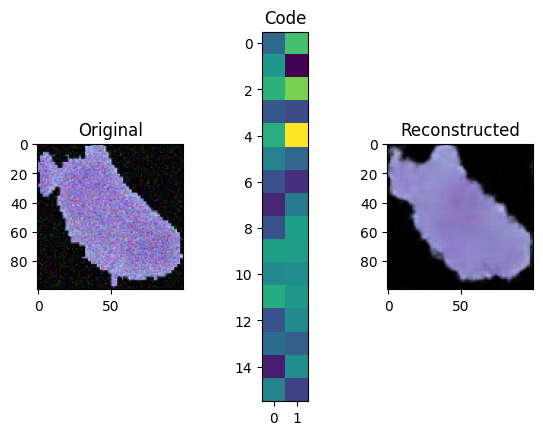

1/1 [==============================] - 0s 30ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


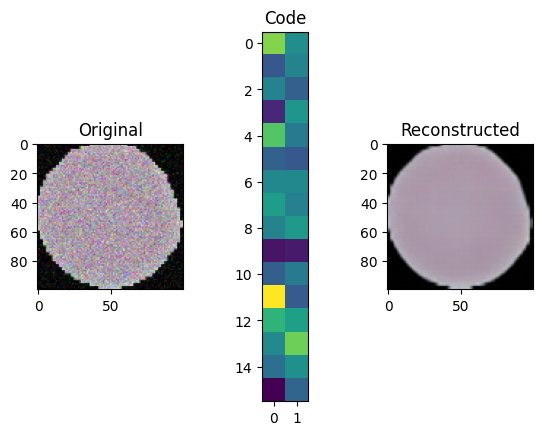

In [38]:
denoising_mse = denoising_autoencoder.evaluate(test_dataset, steps=test_steps)
print("Denoising MSE:", denoising_mse)

for i in range(5):
    idx = random.randint(0, len(X_test))
    img = apply_gaussian_noise(normalize_img(load_malaria_image(X_test[idx])))
    plt.figure()
    visualize(img, encoder, decoder)
    plt.show()

Notebook completed, congratulations!

**What's next?** You can now try to use the code produced by the coder part of the autoencoder to classify the images into parasitized and unaffected ones. You can try to use the CNN of Lab 2 or implement other machine learning approaches, e.g., support vector machines (SVMs) (documentation [here](https://scikit-learn.org/stable/modules/svm.html)) or K-means (documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)) as done in Lab 1.